<div style="background-color: #addbf7; padding: 20px; border-radius: 5px;">
    <p style="font-size: 18px; font-weight: bold;">Introduction:</p>
    <p>This notebook was created with great inspiration from the Kaggle user <a href="https://www.kaggle.com/havinath">Bingi</a> for an image segmentation Kaggle-challenge, where it even landed the best score.</p>
    <p>Later, I reused the code with some small adjustments in order to preprocess thousands of OCT-images to create a training dataset for my GAN while working on my bachelor thesis.</p>
    <p>Check out the original notebook <a href="https://www.kaggle.com/code/havinath/object-detection-using-pytorch-training" target="_blank">here</a>.</p>
</div>

## Import Packages

In [7]:
import os
import cv2
import re
import time
import datetime
import ast
import glob
import numpy as np
import pandas as pd
import torch
import torchvision
import json
import torchvision.transforms as transforms
import albumentations as A

from PIL import Image
from IPython.display import Image as ImageDisplay
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
from numba import jit
from typing import List, Union, Tuple

from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import warnings
warnings.filterwarnings("ignore")

print(f"Is Cuda available? {torch.cuda.is_available()}")

Is Cuda available? True


## Specify class, paths, etc.

In [9]:
# Choose: CNV | DME | DRUSEN | NORMAL
CLASS = "CNV"

# Train directory
dir_train = os.path.join("X:", os.sep, "PracticalWork", "trainOCT")

# Test directory
dir_test = os.path.join("X:", os.sep, "PracticalWork", "testOCT")
    
# Path to the dataset that should be labelled
image_dir = os.path.join("X:", os.sep, "PracticalWork", "OCT", "train")
out_dir = os.path.join("X:", os.sep, "PracticalWork", "OCTout")
images_path_test = glob.glob(f'{image_dir}/{CLASS}/*.jpeg', recursive=True)
images_path_test = glob.glob(f'{os.path.join(image_dir, CLASS)}/*.jpeg', recursive=True)

# Set the target image size
size = 256

# Define the file with all the labels in the COCO-format
file = os.path.join(os.getcwd(), "result.json")

# Inputs required for training
model_path = os.path.join(os.getcwd(), "fasterrcnn_resnet50_fpn2_17July.pth")
early_stop = 1 #This is required for early stopping, the number of epochs we will wait with no improvement before stopping

In [10]:
def colorSqueeze(r, g, b):
    return r / 255, g / 255, b / 255

jkuBlue = colorSqueeze(4, 110, 152)
jkuCyan = colorSqueeze(92,207,203)
jkuYellow = colorSqueeze(251,186,0)
jkuGrey = colorSqueeze(128,130,136)
jkuDarkGrey = colorSqueeze(90,90,90)
jkuLightGreen = colorSqueeze(187,208,50)
jkuGreen = colorSqueeze(76,172,78)
jkuPurple = colorSqueeze(156,71,123)
jkuRed = colorSqueeze(231,55,41)

colors=[jkuBlue, jkuLightGreen, jkuRed, jkuYellow]

## Create the training Dataframe:

In [11]:
# Append all the training images (the ones where we have labels)
images_im_train = []
images_path_train = []

for filename in glob.glob(f'{dir_train}/*.jpeg', recursive=True): #assuming JPEG
    im = Image.open(filename)
    images_im_train.append(im)
    images_path_train.append(filename)

In [12]:
# Open the JSON file
with open(file, 'r') as f:
    # Load the contents of the file into a dictionary
    data = json.load(f)

my_columns = ['image_id', 'path', 'shapex', 'shapey', 'x', 'y', 'w', 'h']
my_data = {col: [] for col in my_columns}

my_dataframe = pd.DataFrame(data=my_data)

# Initialize the image ids
image_ids = []

for my_dict in data['images']:
    image_ids.append(my_dict['id'])

my_dataframe['image_id'] = image_ids

# Loop over annotations
for annot in data['annotations']:
    cur_image_id = annot['image_id']
    cur_image_rows = my_dataframe['image_id'] == cur_image_id
    
    my_dataframe.loc[cur_image_rows, 'x'] = int(annot['bbox'][0])
    my_dataframe.loc[cur_image_rows, 'y'] = int(annot['bbox'][1])
    my_dataframe.loc[cur_image_rows, 'w'] = int(annot['bbox'][2])
    my_dataframe.loc[cur_image_rows, 'h'] = int(annot['bbox'][3])
    
# Loop over annotations
for annot in data['images']:
    cur_image_id = annot['id']
    
    my_dataframe.loc[cur_image_id, 'path'] = os.path.join(dir_train, annot['file_name'][16:])
    my_dataframe.loc[cur_image_id, 'shapex'] = int(annot['width'])
    my_dataframe.loc[cur_image_id, 'shapey'] = int(annot['height'])
    
my_dataframe = my_dataframe.dropna()

# Convert selected columns to integers
my_dataframe.loc[:, ['shapex', 'shapey', 'x', 'y', 'w', 'h']] = my_dataframe.loc[:, ['shapex', 'shapey', 'x', 'y', 'w', 'h']].astype(int)
my_dataframe['path'] = my_dataframe['path'].astype('str') 

In [13]:
# Fill the dataframe
scalx = my_dataframe['shapex'] / size
scaly = my_dataframe['shapey'] / size

my_dataframe['x'] /= scalx
my_dataframe['y'] /= scaly
my_dataframe['w'] /= scalx
my_dataframe['h'] /= scaly

my_dataframe['shapex'] = size
my_dataframe['shapey'] = size

my_dataframe.loc[:, ['shapex', 'shapey', 'x', 'y', 'w', 'h']] = my_dataframe.loc[:, ['shapex', 'shapey', 'x', 'y', 'w', 'h']].astype(int)

train_df = my_dataframe

In [14]:
train_df['x'] = np.array(train_df['x'], dtype=np.float64)
train_df['y'] = np.array(train_df['y'], dtype=np.float64)
train_df['w'] = np.array(train_df['w'], dtype=np.float64)
train_df['h'] = np.array(train_df['h'], dtype=np.float64)
train_df

,image_id,path,shapex,shapey,x,y,w,h
1,1,X:\PracticalWork\trainOCT\CNV-53018-2.jpeg,256,256,0.0,51.0,255.0,114.0
2,2,X:\PracticalWork\trainOCT\CNV-81630-1.jpeg,256,256,0.0,71.0,255.0,125.0
3,3,X:\PracticalWork\trainOCT\CNV-81630-2.jpeg,256,256,0.0,42.0,255.0,124.0
4,4,X:\PracticalWork\trainOCT\CNV-81630-3.jpeg,256,256,0.0,13.0,255.0,161.0
5,5,X:\PracticalWork\trainOCT\CNV-81630-4.jpeg,256,256,0.0,26.0,255.0,160.0
...,...,...,...,...,...,...,...,...
995,995,X:\PracticalWork\trainOCT\NORMAL-5193994-1.jpeg,256,256,0.0,70.0,255.0,108.0
996,996,X:\PracticalWork\trainOCT\NORMAL-5246808-1.jpeg,256,256,0.0,61.0,256.0,118.0
997,997,X:\PracticalWork\trainOCT\NORMAL-5246808-2.jpeg,256,256,0.0,52.0,254.0,144.0
998,998,X:\PracticalWork\trainOCT\NORMAL-5324912-1.jpeg,256,256,0.0,60.0,255.0,105.0


## Create the validation Dataframe:

In [9]:
threshold = int(len(train_df['x']) * 0.2)

image_ids = train_df['image_id'].unique() #collecting all unique images
split = int(np.round(len(image_ids) * 0.2))

valid_ids = image_ids[-split:]
train_ids = image_ids[:-split]

print(f"The splitting threshold is: {split}")
print(f"The ratio of valid/train is: {len(valid_ids)}/{len(train_ids)}")

The splitting threshold is: 197
The ratio of valid/train is: 197/786


In [10]:
valid_df = train_df.iloc[range(0, threshold)]
train_df = train_df.iloc[range(threshold, len(train_df['x']))]

In [11]:
valid_df = valid_df.reset_index();
train_df = train_df.reset_index();

In [12]:
# Print the resulting sizes of the dataframes
valid_df.shape, train_df.shape

((196, 9), (787, 9))

In [13]:
train_df

,index,image_id,path,shapex,shapey,x,y,w,h
0,213,213,X:\PracticalWork\trainOCT\CNV-5557306-1.jpeg,256,256,0.0,55.0,254.0,136.0
1,214,214,X:\PracticalWork\trainOCT\CNV-5594757-1.jpeg,256,256,0.0,0.0,255.0,200.0
2,215,215,X:\PracticalWork\trainOCT\CNV-5594757-2.jpeg,256,256,1.0,0.0,253.0,167.0
3,216,216,X:\PracticalWork\trainOCT\CNV-5603164-1.jpeg,256,256,0.0,78.0,254.0,164.0
4,217,217,X:\PracticalWork\trainOCT\CNV-5674369-1.jpeg,256,256,0.0,0.0,254.0,224.0
...,...,...,...,...,...,...,...,...,...
782,995,995,X:\PracticalWork\trainOCT\NORMAL-5193994-1.jpeg,256,256,0.0,70.0,255.0,108.0
783,996,996,X:\PracticalWork\trainOCT\NORMAL-5246808-1.jpeg,256,256,0.0,61.0,256.0,118.0
784,997,997,X:\PracticalWork\trainOCT\NORMAL-5246808-2.jpeg,256,256,0.0,52.0,254.0,144.0
785,998,998,X:\PracticalWork\trainOCT\NORMAL-5324912-1.jpeg,256,256,0.0,60.0,255.0,105.0


In [14]:
valid_df

,index,image_id,path,shapex,shapey,x,y,w,h
0,1,1,X:\PracticalWork\trainOCT\CNV-53018-2.jpeg,256,256,0.0,51.0,255.0,114.0
1,2,2,X:\PracticalWork\trainOCT\CNV-81630-1.jpeg,256,256,0.0,71.0,255.0,125.0
2,3,3,X:\PracticalWork\trainOCT\CNV-81630-2.jpeg,256,256,0.0,42.0,255.0,124.0
3,4,4,X:\PracticalWork\trainOCT\CNV-81630-3.jpeg,256,256,0.0,13.0,255.0,161.0
4,5,5,X:\PracticalWork\trainOCT\CNV-81630-4.jpeg,256,256,0.0,26.0,255.0,160.0
...,...,...,...,...,...,...,...,...,...
191,208,208,X:\PracticalWork\trainOCT\CNV-5431636-1.jpeg,256,256,0.0,84.0,254.0,142.0
192,209,209,X:\PracticalWork\trainOCT\CNV-5431636-2.jpeg,256,256,1.0,34.0,254.0,161.0
193,210,210,X:\PracticalWork\trainOCT\CNV-5457415-1.jpeg,256,256,1.0,62.0,253.0,154.0
194,211,211,X:\PracticalWork\trainOCT\CNV-5536678-1.jpeg,256,256,0.0,52.0,254.0,132.0


## Create a method to plot an image with a bounding box:

In [15]:
def draw_bounding_box(image_path, x, y, width, height):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to 256x256 pixels
    image = cv2.resize(image, (size, size))
    resized_image = image.copy()
    final_image = image.copy()
    
    # Convert the COCO coordinates to integers
    x, y, width, height = int(x), int(y), int(width), int(height)
    
    # Draw the bounding box on the image
    cv2.rectangle(image, (x, y), (width, y + height), (255, 0, 0), 1)  # Red rectangle
    
    # Create a 1x3 grid of subplots
    fig, axes = plt.subplots(1, 3)

    # Plot the images in each subplot
    axes[0].imshow(resized_image)
    axes[0].axis('off')

    axes[1].imshow(image)
    axes[1].axis('off')
    
    # Open the image
    image = Image.open(image_path)
    image = image.resize((size, size))
    
    # Define the region of interest
    if y < height:        
        roi = image.crop((x, y, width, y + height))
    else:
        roi = image.crop((x, height, width, y + height))        
    
    # Resize the region of interest
    resized_roi = roi.resize((size, size))
    
    # Create a new blank image with the desired size
    resized_image = Image.new('RGB', (size, size))
    
    # Paste the resized region of interest onto the new image
    resized_image.paste(resized_roi, (0, 0))    
    
    axes[2].imshow(resized_image)
    axes[2].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the grid of images
    plt.show()

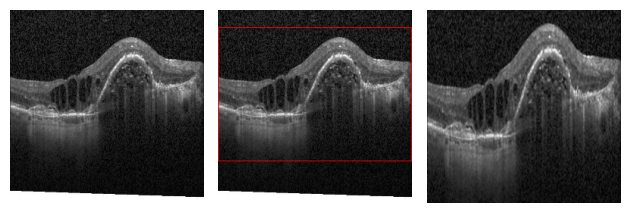

In [16]:
i = 12
draw_bounding_box(train_df['path'].iloc[i], 0, train_df['y'].iloc[i], 255, train_df['h'].iloc[i])

## Create a class for the Dataset:

In [17]:
class OCTDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id] # Getting all coordinates for the given image
        img_path = records['path'].iloc[0]
        
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (size, size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= float(size - 1)

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area,dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

## Albumentations
Albumentations is a Python library for fast and flexible image augmentations. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance, and does so while providing a concise, yet powerful image augmentation interface for different computer vision tasks, including object classification, segmentation, and detection.

In [18]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Model - Transfer learning
Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

Here we will construct a Faster R-CNN model with a ResNet-50-FPN backbone, luckily we have the pretrained version available in PyTorch.

More explanation and implementation details here - https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [19]:
# Load a pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(box_detections_per_img=1, pretrained=True)

## Modifying model for our task
We now have to modify the loaded model for the task at hand, in most of the cases it would be the number of output classes. In some cases it would be the last FC layer for the task at hand.

In [20]:
num_classes = 2  # 1 class (OCT) + background

# Get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## Helper functions for training

In [21]:
# Function to calculate loss for every epoch
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

## Dataloader
In a lot of cases like this we cannot hold the training data in the memory and hence we make use of dataloders so that the required training data can be held in the memory on the fly during training

In [22]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = OCTDataset(train_df, dir_train, get_train_transform())
valid_dataset = OCTDataset(valid_df, dir_train, get_valid_transform())

# Split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

## IOU Calculation
The Intersection over Union (IoU) measurement is a mathematical evaluation that quantifies the degree of overlap between two sets by dividing the intersection area by the union area, providing a normalized value ranging from 0 to 1 to assess the similarity or dissimilarity between them.

In [23]:
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [24]:
@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

## WBF approach for ensemble
We will used weighted box fusion to collate multiple boxes - https://arxiv.org/pdf/1910.13302.pdf

In our case we only have one model, but we can save different models for each folds and then get the result from each model and then apply WBF to ensemble.

Another useful ressource - https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble

In [25]:
models = [model]
from ensemble_boxes import *

def make_ensemble_predictions(images):
    images = list(image.to(device) for image in images)    
    result = []
    for net in models:
        net.eval()
        outputs = net(images)
        result.append(outputs)
    return result

def run_wbf(predictions, image_index, image_size=640, iou_thr=0.55, skip_box_thr=0.5, weights=None):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

## Training
We are using SGD optimizer here without scheduler.

We are using EarlyStopping. It is implemented almost everywhere as it is very easy to implement i.e. hold a copy of weights when validation IOU (or accuracy or f1) increases and at the end of the training use the best weights. A easy powerful way to prevent overfitting.

We can make this training more efficient by using Adam optimizer with a smaller learning rate and using ReduceLROnPlateau scheduler.

https://pytorch.org/docs/stable/optim.html#torch.optim.Adam

https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Current device:", device)

Current device: cuda


In [27]:
# Configure the training parameters
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

num_epochs = 10

In [28]:
do_train = True

if do_train:
    loss_hist = Averager()
    best_val = None
    patience = early_stop
    for epoch in tqdm(range(num_epochs)):
        start_time = time.time()
        itr = 1
        loss_hist.reset()
        model.train()
        for images, targets, image_ids in train_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]#[{k: v.double().to(device) if k =='boxes' else v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1

        # Update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()


        # At every epoch we will also calculate the validation IOU
        validation_image_precisions = []
        iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
        model.eval()
        for images, targets, imageids in valid_data_loader: #return image, target, image_id
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]
            #outputs = model(images) 

            predictions = make_ensemble_predictions(images)

            for i, image in enumerate(images):
                boxes, scores, labels = run_wbf(predictions, image_index=i)

                boxes = boxes.astype(np.int32).clip(min=0, max=1022553)

                preds = boxes#outputs[i]['boxes'].data.cpu().numpy()
                #scores = outputs[i]['scores'].data.cpu().numpy()
                preds_sorted_idx = np.argsort(scores)[::-1]
                preds_sorted = preds[preds_sorted_idx]
                gt_boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
                image_precision = calculate_image_precision(preds_sorted,
                                                        gt_boxes,
                                                        thresholds=iou_thresholds,
                                                        form='coco')

                validation_image_precisions.append(image_precision)
        val_iou = np.mean(validation_image_precisions)
        print(f"Epoch #{epoch+1} loss: {loss_hist.value}","Validation IOU: {0:.4f}".format(val_iou),"Time taken :",str(datetime.timedelta(seconds=time.time() - start_time))[:7])
        if not best_val:
            best_val = val_iou  # So any validation roc_auc we have is the best one for now
            print("Saving model")
            torch.save(model, model_path)  # Saving the model
            #continue
        if val_iou >= best_val:
            print("Saving model as IOU is increased from",best_val,"to",val_iou)
            best_val = val_iou
            patience = early_stop  # Resetting patience since we have new best validation accuracy
            torch.save(model, model_path)  # Saving current best model torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best Validation IOU: {:.3f}'.format(best_val))
                break

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Iteration #50 loss: 0.0660184994339943
Iteration #100 loss: 0.06895396113395691
Iteration #150 loss: 0.030089490115642548
Epoch #1 loss: 0.06489938395428778 Validation IOU: 0.9957 Time taken : 0:00:55
Saving model
Saving model as IOU is increased from 0.9957482993197277 to 0.9957482993197277


 10%|████████▎                                                                          | 1/10 [00:56<08:28, 56.46s/it]

Iteration #50 loss: 0.03831331804394722
Iteration #100 loss: 0.05431538075208664
Iteration #150 loss: 0.01886615715920925
Epoch #2 loss: 0.03340752733880796 Validation IOU: 0.9966 Time taken : 0:00:46
Saving model as IOU is increased from 0.9957482993197277 to 0.9965986394557822


 20%|████████████████▌                                                                  | 2/10 [01:43<06:46, 50.81s/it]

Iteration #50 loss: 0.03491221368312836
Iteration #100 loss: 0.0361294262111187
Iteration #150 loss: 0.017423812299966812
Epoch #3 loss: 0.029315760472628672 Validation IOU: 0.9983 Time taken : 0:00:46
Saving model as IOU is increased from 0.9965986394557822 to 0.998299319727891


 30%|████████████████████████▉                                                          | 3/10 [02:30<05:43, 49.06s/it]

Iteration #50 loss: 0.03246092423796654
Iteration #100 loss: 0.02314349077641964
Iteration #150 loss: 0.016819719225168228
Epoch #4 loss: 0.02479684086242303 Validation IOU: 1.0000 Time taken : 0:00:48
Saving model as IOU is increased from 0.998299319727891 to 0.9999999999999999


 40%|█████████████████████████████████▏                                                 | 4/10 [03:18<04:53, 48.87s/it]

Iteration #50 loss: 0.03240338712930679
Iteration #100 loss: 0.0297617819160223
Iteration #150 loss: 0.01623038947582245


 40%|█████████████████████████████████▏                                                 | 4/10 [04:07<06:10, 61.80s/it]

Epoch #5 loss: 0.02421700022169176 Validation IOU: 0.9983 Time taken : 0:00:48
Early stopping. Best Validation IOU: 1.000


## Loading best model

In [29]:
model = torch.load(model_path)

## Prepare testing environment:

In [30]:
test_df = pd.DataFrame()
test_df['image_id'] = images_path_test
# test_df['image_id'] = images_path_test[0:100]

test_df

,image_id
0,X:\PracticalWork\OCT\train\CNV\CNV-1016042-1.jpeg
1,X:\PracticalWork\OCT\train\CNV\CNV-1016042-10....
2,X:\PracticalWork\OCT\train\CNV\CNV-1016042-100...
3,X:\PracticalWork\OCT\train\CNV\CNV-1016042-101...
4,X:\PracticalWork\OCT\train\CNV\CNV-1016042-102...
...,...
37200,X:\PracticalWork\OCT\train\CNV\CNV-9997680-95....
37201,X:\PracticalWork\OCT\train\CNV\CNV-9997680-96....
37202,X:\PracticalWork\OCT\train\CNV\CNV-9997680-97....
37203,X:\PracticalWork\OCT\train\CNV\CNV-9997680-98....


In [31]:
class OCTTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        # print(image_id)
        image = cv2.imread(image_id, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= float(size - 1)

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

## Define test dataloader:

In [32]:
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [33]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = OCTTestDataset(test_df, dir_test, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [34]:
model.eval();

## Generate Test predictions
We will generate predictions of test images and will also store the value to plot the detected objects

In [35]:
# Create an empty DataFrame
result_df = pd.DataFrame(columns=['path', 'shapex', 'shapey', 'x', 'y', 'width', 'height'])

# Print the empty DataFrame
result_df

,path,shapex,shapey,x,y,width,height


In [36]:
# Create a function that adjusts brightness
def adjust_brightness(image):
    # Find the minimum and maximum pixel values
    min_value = np.min(image)
    max_value = np.max(image)

    # Calculate the scaling factor
    scaling_factor = max_value - min_value

    # Adjust the brightness of the image
    adjusted_image = image - min_value
    normalized_image = adjusted_image / scaling_factor

    return normalized_image

In [37]:
# Cre
torch.cuda.empty_cache()

detection_threshold = 0.5
results = []
outputs = []
resize_transform = transforms.Resize((size, size))
c = 0

for images, image_ids in tqdm(test_data_loader):
    images = list(image.to(device) for image in images)
    predictions = make_ensemble_predictions(images)

    for i, image in enumerate(images):
        w = image.shape[2]
        h = image.shape[1]
        s = max(w, h)
        scale = max(w, h) / min(w, h)
        
        # Resize the image to s * s
        image = adjust_brightness(image.permute(1, 2, 0).cpu().numpy())
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        image = cv2.resize(image.permute(1, 2, 0).cpu().numpy(), (s, s))
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        
        boxes, scores, labels = run_wbf(predictions, image_index=i)

        boxes = boxes.astype(np.int32).clip(min=0, max=s-1)
            
        preds = boxes
        preds_sorted_idx = np.argsort(scores)[::-1]
        preds_sorted = preds[preds_sorted_idx]
        boxes = preds     
        
        # Crop the image using the bounding box coordinates
        try:
            topmost_y = min(boxes[:, 1])
        except:
            topmost_y = 0
            
        try:
            bottommost_y = max(boxes[:, 3])
        except:
            bottommost_y = s-1
            
        bottommost_y = int(bottommost_y * scale)
        topmost_y = int(topmost_y * scale)
        
        if bottommost_y <= topmost_y:
            image = image[:, bottommost_y:topmost_y, 0:s]
        else:
            image = image[:, topmost_y:bottommost_y, 0:s]
            
        # Convert tensor to numpy array
        np_array = image.numpy()

        # Reshape numpy array to (s, s, 3)
        np_array = np.transpose(np_array, (1, 2, 0))

        # Convert numpy array to OpenCV image
        cv2_image = cv2.cvtColor(np_array, cv2.COLOR_RGB2BGR)
        
        # Reshape the image to (s, s)
        resized_img = cv2.resize(cv2_image, (size, size))
        out_path = os.path.join(out_dir, CLASS, f"{str(c).zfill(5)}.jpg")
        cv2.imwrite(out_path, resized_img * 256)        
        c += 1
        
        # Create a row of data
        new_row = {
            'path': image_ids[i],
            'shapex': size,
            'shapey': size,
            'x': 0,
            'y': int(bottommost_y * size / s),
            'width': size-1,
            'height': int(topmost_y * size / s)
        }

        # Append the row to the DataFrame
        result_df = result_df.append(new_row, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████| 37205/37205 [38:16<00:00, 16.20it/s]


In [38]:
result_df

,path,shapex,shapey,x,y,width,height
0,X:\PracticalWork\OCT\train\CNV\CNV-1016042-1.jpeg,256,256,0,164,255,42
1,X:\PracticalWork\OCT\train\CNV\CNV-1016042-10....,256,256,0,165,255,21
2,X:\PracticalWork\OCT\train\CNV\CNV-1016042-100...,256,256,0,244,255,66
3,X:\PracticalWork\OCT\train\CNV\CNV-1016042-101...,256,256,0,251,255,115
4,X:\PracticalWork\OCT\train\CNV\CNV-1016042-102...,256,256,0,251,255,115
...,...,...,...,...,...,...,...
37200,X:\PracticalWork\OCT\train\CNV\CNV-9997680-95....,256,256,0,186,255,64
37201,X:\PracticalWork\OCT\train\CNV\CNV-9997680-96....,256,256,0,189,255,63
37202,X:\PracticalWork\OCT\train\CNV\CNV-9997680-97....,256,256,0,252,255,35
37203,X:\PracticalWork\OCT\train\CNV\CNV-9997680-98....,256,256,0,232,255,12


## Create a Boxplot to see how many pixels were cut:

In [39]:
def create_custom_boxplot(data, color):
    fig, ax = plt.subplots()
    
    # Create a boxplot with custom color
    boxplot = ax.boxplot(data, patch_artist=True, widths=0.5)
    
    # Set the color for all elements of the boxplot
    for patch in boxplot['boxes']:
        patch.set_facecolor(color)
    
    # Set the color for the whiskers, caps, medians, and outliers
    # for patch in boxplot['whiskers']:
    #     patch.set_color(color)
    # for patch in boxplot['caps']:
    #     patch.set_color(color)
    for patch in boxplot['medians']:
        patch.set_color('black')
    for patch in boxplot['fliers']:
        patch.set_markerfacecolor(color)
        patch.set_markeredgecolor(color)
        patch.set_alpha(0.005)
    
    plt.show()

In [40]:
# Change values above size to size
result_df.loc[:, 'y'] = np.minimum(result_df['y'], size)
result_df.loc[:, 'height'] = np.minimum(result_df['height'], size)

difference = abs(result_df['y'] - result_df['height'])
    
result_df['difference'] = difference
result_df

,path,shapex,shapey,x,y,width,height,difference
0,X:\PracticalWork\OCT\train\CNV\CNV-1016042-1.jpeg,256,256,0,164,255,42,122
1,X:\PracticalWork\OCT\train\CNV\CNV-1016042-10....,256,256,0,165,255,21,144
2,X:\PracticalWork\OCT\train\CNV\CNV-1016042-100...,256,256,0,244,255,66,178
3,X:\PracticalWork\OCT\train\CNV\CNV-1016042-101...,256,256,0,251,255,115,136
4,X:\PracticalWork\OCT\train\CNV\CNV-1016042-102...,256,256,0,251,255,115,136
...,...,...,...,...,...,...,...,...
37200,X:\PracticalWork\OCT\train\CNV\CNV-9997680-95....,256,256,0,186,255,64,122
37201,X:\PracticalWork\OCT\train\CNV\CNV-9997680-96....,256,256,0,189,255,63,126
37202,X:\PracticalWork\OCT\train\CNV\CNV-9997680-97....,256,256,0,252,255,35,217
37203,X:\PracticalWork\OCT\train\CNV\CNV-9997680-98....,256,256,0,232,255,12,220


In [41]:
# Save the vector to a file
np.save(f'{CLASS}.npy', result_df['difference'])
print("Saved", f'{CLASS}.npy')

Saved CNV.npy


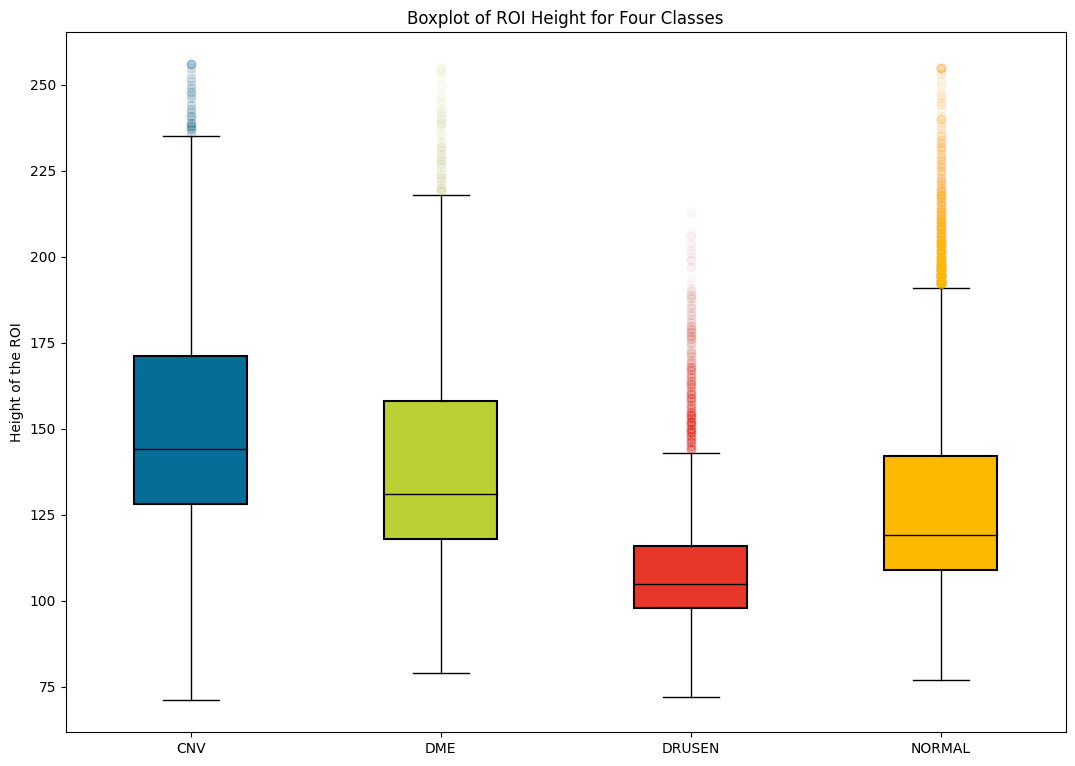

In [41]:
data_2 = np.load(f'DME.npy', allow_pickle=True)
data_3 = np.load(f'DRUSEN.npy', allow_pickle=True)
data_4 = np.load(f'NORMAL.npy', allow_pickle=True)
data = [data_1, data_2, data_3, data_4]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot with patch_artist=True for individual color customization
bp = ax.boxplot(data, patch_artist=True)

for fliers, color in zip(bp['fliers'], colors):
    # fliers.set(marker='o', color=color)
    fliers.set_markerfacecolor(color)
    fliers.set_markeredgecolor(color)
    fliers.set_alpha(0.01)
    
# Customize medians color
for median in bp['medians']:
    median.set_color('black')

# Customize boxplot colors (optional)
for box, color in zip(bp['boxes'], colors):
    box.set(color='black', linewidth=1.5)
    box.set(facecolor=color)

# Customizing other plot elements (optional)
ax.set_xticklabels(['CNV', 'DME', 'DRUSEN', 'NORMAL'])
# ax.set_xlabel('Classes')
ax.set_ylabel('Height of the ROI')
ax.set_title('Boxplot of ROI Height for Four Classes')

# Show the plot
# plt.figure(dpi=300);  # Set DPI to 300
plt.show()